In [1]:
import gc
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import noise_module
from mpi4py import MPI
from scipy.fftpack.helper import next_fast_len
import matplotlib.pyplot  as plt

# ignore warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

'''
This main script of NoisePy:
    1) read the saved noise data in user-defined chunk of inc_hours, cut them into smaller length segments, do 
    general pre-processing (trend, normalization) and then do FFT;
    2) save all FFT data of the same time chunk in memory;
    3) performs cross-correlation for all station pairs in the same time chunk and output the sub-stacked (if 
    selected) into ASDF format;

Authors: Chengxin Jiang (chengxin_jiang@fas.harvard.edu)
         Marine Denolle (mdenolle@fas.harvard.edu)
        
NOTE:
    0. MOST occasions you just need to change parameters followed with detailed explanations to run the script. 
    1. To read SAC/mseed files, we assume the users have sorted the data by the time chunk they prefer (e.g., 1day) 
        and store them in folders named after the time chunk (e.g, 2010_10_1). modify L135 to find your local data; 
    2. A script of S0B_to_ASDF.py is provided to help clean messy SAC/MSEED data and convert them into ASDF format.
        the script takes minor time compared to that for cross-correlation. so we recommend to use S0B script for
        better NoisePy performance. the downside is that it duplicates the continuous noise data on your machine;
    3. When "coherency" is preferred, please set "freq_norm" to "rma" and "time_norm" to "no" for better performance.
'''

tt0=time.time()

########################################
#########PARAMETER SECTION##############
########################################

# absolute path parameters
rootpath  = r'/Users/iotsoftwareengineer/cross-correlation-noisepy'                                      # root path for this data processing
CCFDIR    = os.path.join(rootpath,'CCF')                                    # dir to store CC data
DATADIR   = os.path.join(rootpath,'Data Stasiun')                               # dir where noise data is located
local_data_path = os.path.join(rootpath,'Data Stasiun')                         # absolute dir where SAC files are stored: this para is VERY IMPORTANT and has to be RIGHT if input_fmt is not h5 for asdf!!!
locations = os.path.join(DATADIR,'station.txt')                             # station info including network,station,channel,latitude,longitude,elevation: only needed when input_fmt is not h5 for asdf

# some control parameters
input_fmt   = 'SAC'                                                          # string: 'h5', 'sac','mseed' 
freq_norm   = 'rma'                                                         # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'no'                                                          # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'                                                       # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
flag        = True                                                          # print intermediate variables and computing time for debugging purpose
acorr_only  = False                                                         # only perform auto-correlation 
xcorr_only  = True                                                          # only perform cross-correlation or not
ncomp       = 1                                                             # 1 or 3 component data (needed to decide whether do rotation)

# station/instrument info for input_fmt=='sac' or 'mseed'
stationxml = False                                                          # station.XML file used to remove instrument response for SAC/miniseed data
rm_resp   = 'no'                                                            # select 'no' to not remove response and use 'inv','spectrum','RESP', or 'polozeros' to remove response
respdir   = os.path.join(rootpath,'no')                                   # directory where resp files are located (required if rm_resp is neither 'no' nor 'inv')
# read station list
if input_fmt != 'h5':
    if not os.path.isfile(locations): 
        raise ValueError('Abort! station info is needed for this script')   
    locs = pd.read_csv(locations)
    

# pre-processing parameters 
cc_len    = 1800                                                            # basic unit of data length for fft (sec)
step      = 450                                                             # overlapping between each cc_len (sec)
smooth_N  = 10                                                              # moving window length for time/freq domain normalization if selected (points)

# cross-correlation parameters
maxlag         = 100                                                        # lags of cross-correlation to save (sec)
substack       = True                                                       # True = smaller stacks within the time chunk. False: it will stack over inc_hours
                                                                            # for instance: substack=True, substack_len=cc_len means that you keep ALL of the correlations
                                                                            # if substack=True, substack_len=2*cc_len, then you pre-stack every 2 correlation windows.
substack_len   = cc_len                                                     # how long to stack over (for monitoring purpose): need to be multiples of cc_len
smoothspect_N  = 10                                                         # moving window length to smooth spectrum amplitude (points)

# criteria for data selection
max_over_std = 1000                                                           # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

# maximum memory allowed per core in GB
MAX_MEM = 4.0

# load useful download info if start from ASDF
if input_fmt == 'h5':
    dfile = os.path.join(DATADIR,'fft_cc_data.txt')
    down_info = eval(open(dfile).read())
    samp_freq = down_info['samp_freq']
    freqmin   = down_info['freqmin']
    freqmax   = down_info['freqmax']
    start_date = down_info['start_date']
    end_date   = down_info['end_date']
    inc_hours  = down_info['inc_hours']  
    ncomp      = down_info['ncomp'] 
else:   # sac or mseed format
    samp_freq = 10
    freqmin   = 0.01
    freqmax   = 10
    start_date = ["2004.202.00.00.00.000"]
    end_date   = ["2004.202.00.00.00.000"]
    inc_hours  = 24
dt = 1/samp_freq

##################################################
# we expect no parameters need to be changed below

# make a dictionary to store all variables: also for later cc
fc_para={'samp_freq':samp_freq,
         'dt':dt,
         'cc_len':cc_len,
         'step':step,
         'freqmin':freqmin,
         'freqmax':freqmax,
         'freq_norm':freq_norm,
         'time_norm':time_norm,
         'cc_method':cc_method,
         'smooth_N':smooth_N,
         'rootpath':rootpath,
         'CCFDIR':CCFDIR,
         'start_date':start_date[0],
         'end_date':end_date[0],
         'inc_hours':inc_hours,
         'substack':substack,
         'substack_len':substack_len,
         'smoothspect_N':smoothspect_N,
         'maxlag':maxlag,
         'max_over_std':max_over_std,
         'ncomp':ncomp,
         'stationxml':stationxml,
         'rm_resp':rm_resp,
         'respdir':respdir,
         'input_fmt':input_fmt}
# save fft metadata for future reference
fc_metadata  = os.path.join(CCFDIR,'fft_cc_data.txt')       

#######################################
###########PROCESSING SECTION##########
#######################################

#--------MPI---------
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    if not os.path.isdir(CCFDIR):os.mkdir(CCFDIR)
    
    # save metadata 
    fout = open(fc_metadata,'w')
    fout.write(str(fc_para));fout.close()

    # set variables to broadcast
    if input_fmt == 'h5':
        tdir = sorted(glob.glob(os.path.join(DATADIR,'*.h5')))
        
    else:
        tdir = sorted(glob.glob(local_data_path))
        if len(tdir)==0: raise ValueError('No data file in %s',DATADIR)
        # get nsta by loop through all event folder
        nsta = 0
        for ii in range(len(tdir)):
            tnsta = len(glob.glob(os.path.join(tdir[ii],'*'+input_fmt)))
            if nsta<tnsta:nsta=tnsta

    nchunk = len(tdir)
    splits  = nchunk
    if nchunk==0:
        raise IOError('Abort! no available seismic files for FFT')
else:
    if input_fmt == 'h5':
        splits,tdir = [None for _ in range(2)]
    else: splits,tdir,nsta = [None for _ in range(3)]

# broadcast the variables
splits = comm.bcast(splits,root=0)
tdir  = comm.bcast(tdir,root=0)
if input_fmt != 'h5': nsta = comm.bcast(nsta,root=0)

# MPI loop: loop through each user-defined time chunk
for ick in range (rank,splits,size):
    t10=time.time()   

    #############LOADING NOISE DATA AND DO FFT##################

    # get the tempory file recording cc process
    if input_fmt == 'h5':
        tmpfile = os.path.join(CCFDIR,tdir[ick].split('/')[-1].split('.')[0]+'.tmp')
        
    else: 
        tmpfile = os.path.join(CCFDIR,tdir[ick].split('/')[-1]+'.tmp')
    
    # check whether time chunk been processed or not
    if os.path.isfile(tmpfile):
        ftemp = open(tmpfile,'r')
        alines = ftemp.readlines()
        if len(alines) and alines[-1] == 'done':
            continue
        else:
            ftemp.close()
            os.remove(tmpfile)
    
    # retrive station information
    if input_fmt == 'h5':
        ds=pyasdf.ASDFDataSet(tdir[ick],mpi=False,mode='r') 
        sta_list = ds.waveforms.list()
        nsta=ncomp*len(sta_list)
        print('found %d stations in total'%nsta)
    else:
        sta_list = sorted(glob.glob(os.path.join(tdir[ick],'*'+input_fmt)))
    if (len(sta_list)==0):
        print('continue! no data in %s'%tdir[ick]);continue
    
    # crude estimation on memory needs (assume float32)
    nsec_chunk = inc_hours/24*86400
    nseg_chunk = int(np.floor((nsec_chunk-cc_len)/step))
    npts_chunk = int(nseg_chunk*cc_len*samp_freq)
    memory_size = nsta*npts_chunk*4/1024**3
    if memory_size > MAX_MEM:
        raise ValueError('Require %5.3fG memory but only %5.3fG provided)! Reduce inc_hours to avoid this issue!' % (memory_size,MAX_MEM))

    nnfft = int(next_fast_len(int(cc_len*samp_freq)))
    # open array to store fft data/info in memory
    fft_array = np.zeros((nsta,nseg_chunk*(nnfft//2)),dtype=np.complex64)
    fft_std   = np.zeros((nsta,nseg_chunk),dtype=np.float32)
    fft_flag  = np.zeros(nsta,dtype=np.int16)
    fft_time  = np.zeros((nsta,nseg_chunk),dtype=np.float64) 
    # station information (for every channel)
    station=[];network=[];channel=[];clon=[];clat=[];location=[];elevation=[]     

    # loop through all stations
    iii = 0
    for ista in range(len(sta_list)):
        tmps = sta_list[ista]

        if input_fmt == 'h5':
            # get station and inventory
            try:
                inv1 = ds.waveforms[tmps]['StationXML']
            except Exception as e:
                print('abort! no stationxml for %s in file %s'%(tmps,tdir[ick]))
                continue
            sta,net,lon,lat,loc = noise_module.sta_info_from_inv(inv1)

            # get days information: works better than just list the tags 
            all_tags = ds.waveforms[tmps].get_waveform_tags()
            if len(all_tags)==0:continue
        
        else: # get station information
            all_tags = [1]
            sta = tmps.split('/')[-1]
       
        #----loop through each stream----
        for itag in range(len(all_tags)):
            if flag:print("working on station %s and trace %s" % (sta,all_tags[itag]))
            
            # read waveform data
            if input_fmt == 'h5':
                source = ds.waveforms[tmps][all_tags[itag]]
            else:
                source = obspy.read(tmps)
                source[0].stats.sac["stel"] = 0 #elevation
                source[0].stats.sac["cmpaz"] = 0 #azimuth
                source[0].stats.sac["cmpinc"] = 0
                print(fc_para['input_fmt'], "fc_para")
                inv1   = noise_module.stats2inv(source[0].stats,fc_para,locs)
                a = noise_module.sta_info_from_inv(inv1)
                
                # ('AFB', 'MX', 109.77509307861328, -7.626959800720215, 0.0, '00')
                sta,net,lon,lat,loc, el = noise_module.sta_info_from_inv(inv1)

            # channel info 
            comp = source[0].stats.channel
            if comp[-1] =='U': comp.replace('U','Z')
            if len(source)==0:continue

            # cut daily-long data into smaller segments (dataS always in 2D)
            trace_stdS,dataS_t,dataS = noise_module.cut_trace_make_stat(fc_para,source)        # optimized version:3-4 times faster
            if not len(dataS): continue
            N = dataS.shape[0]

            # do normalization if needed
            source_white = noise_module.noise_processing(fc_para,dataS)
            Nfft = source_white.shape[1];Nfft2 = Nfft//2
            if flag:print('N and Nfft are %d (proposed %d),%d (proposed %d)' %(N,nseg_chunk,Nfft,nnfft))

            # keep track of station info to write into parameter section of ASDF files
            station.append(sta)
            network.append(net)
            channel.append(comp)
            clon.append(lon)
            clat.append(lat)
            location.append(loc)
            #elevation.append(elv)

            # load fft data in memory for cross-correlations
            data = source_white[:,:Nfft2]
            fft_array[iii] = data.reshape(data.size)
            fft_std[iii]   = trace_stdS
            fft_flag[iii]  = 1
            fft_time[iii]  = dataS_t
            iii+=1
            del trace_stdS,dataS_t,dataS,source_white,data
    
    if input_fmt == 'h5': del ds

    # check whether array size is enough
    if iii!=nsta:
        print('it seems some stations miss data in download step, but it is OKAY!')

    #############PERFORM CROSS-CORRELATION##################
    ftmp = open(tmpfile,'w')
    # make cross-correlations 
    for iiS in range(iii):
        fft1 = fft_array[iiS]
        source_std = fft_std[iiS]
        sou_ind = np.where((source_std<fc_para['max_over_std'])&(source_std>0)&(np.isnan(source_std)==0))[0]
        if not fft_flag[iiS] or not len(sou_ind): continue
                
        t0=time.time()
        #-----------get the smoothed source spectrum for decon later----------
        sfft1 = noise_module.smooth_source_spect(fc_para,fft1)
        sfft1 = sfft1.reshape(N,Nfft2)
        t1=time.time()
        if flag: 
            print('smoothing source takes %6.4fs' % (t1-t0))

        # get index right for auto/cross correlation
        istart=iiS;iend=iii
#             if ncomp==1:
#                 iend=np.minimum(iiS+ncomp,iii)
#             else:
#                 if (channel[iiS][-1]=='Z'): # THIS IS NOT GENERALIZABLE. WE need to change this to the order there are bugs that shifts the components
#                     iend=np.minimum(iiS+1,iii)
#                 elif (channel[iiS][-1]=='N'):
#                     iend=np.minimum(iiS+2,iii)
#                 else:
#                     iend=np.minimum(iiS+ncomp,iii)
            
#         if xcorr_only:
#             if ncomp==1:
#                 istart=np.minimum(iiS+ncomp,iii)
#             else:
#                 if (channel[iiS][-1]=='Z'):
#                     istart=np.minimum(iiS+1,iii)
#                 elif (channel[iiS][-1]=='N'):
#                     istart=np.minimum(iiS+2,iii)
#                 else:
#                     istart=np.minimum(iiS+ncomp,iii)

        #-----------now loop III for each receiver B----------
        for iiR in range(istart,iend):
            if acorr_only:
                if (station[iiR]==station[iiS]):continue
            
            if flag:print('receiver: %s %s %s' % (station[iiR],network[iiR],channel[iiR]))
            if not fft_flag[iiR]: continue
                
            fft2 = fft_array[iiR];sfft2 = fft2.reshape(N,Nfft2)
            receiver_std = fft_std[iiR]

            #---------- check the existence of earthquakes ----------
            rec_ind = np.where((receiver_std<fc_para['max_over_std'])&(receiver_std>0)&(np.isnan(receiver_std)==0))[0]
            bb=np.intersect1d(sou_ind,rec_ind)
            if len(bb)==0:continue

            t2=time.time()
            corr,tcorr,ncorr=noise_module.correlate(sfft1[bb,:],sfft2[bb,:],fc_para,Nfft,fft_time[iiR][bb])
            t3=time.time()

            #---------------keep daily cross-correlation into a hdf5 file--------------
            if input_fmt == 'h5':
                tname = tdir[ick].split('/')[-1]
            else: 
                tname = tdir[ick].split('/')[-1]+'.h5'
            cc_h5 = os.path.join(CCFDIR,tname)
            crap  = np.zeros(corr.shape,dtype=corr.dtype)

            with pyasdf.ASDFDataSet(cc_h5,mpi=False) as ccf_ds:
                coor = {'lonS':clon[iiS],
                        'latS':clat[iiS],
                        'lonR':clon[iiR],
                        'latR':clat[iiR]}
                comp = channel[iiS][-1]+channel[iiR][-1]
                parameters = noise_module.cc_parameters(fc_para,coor,tcorr,ncorr,comp)

                # source-receiver pair
                data_type = network[iiS]+'.'+station[iiS]+'_'+network[iiR]+'.'+station[iiR]
                path = channel[iiS]+'_'+channel[iiR]
                crap[:] = corr[:]
                ccf_ds.add_auxiliary_data(data=crap, 
                                          data_type=data_type, 
                                          path=path, 
                                          parameters=parameters)
                ftmp.write(network[iiS]+'.'+station[iiS]+'.'+channel[iiS]+'_'+network[iiR]+'.'+station[iiR]+'.'+channel[iiR]+'\n')

            t4=time.time()
            if flag:print('read S %6.4fs, cc %6.4fs, write cc %6.4fs'% ((t1-t0),(t3-t2),(t4-t3)))
            
            del fft2,sfft2,receiver_std
        del fft1,sfft1,source_std

    # create a stamp to show time chunk being done
    ftmp.write('done')
    ftmp.close()

    fft_array=[];fft_std=[];fft_flag=[];fft_time=[]
    n = gc.collect();print('unreadable garbarge',n)

    t11 = time.time()
    print('it takes %6.2fs to process the chunk of %s' % (t11-t10,tdir[ick].split('/')[-1]))

tt1 = time.time()
print('it takes %6.2fs to process step 1 in total' % (tt1-tt0))
comm.barrier()

# merge all path_array and output
if rank == 0:
    sys.exit()


working on station 2004.202.00.00.00.000.MX.AFB.BHE.SAC and trace 1
SAC fc_para
{'samp_freq': 10, 'dt': 0.1, 'cc_len': 1800, 'step': 450, 'freqmin': 0.01, 'freqmax': 10, 'freq_norm': 'rma', 'time_norm': 'no', 'cc_method': 'xcorr', 'smooth_N': 10, 'rootpath': '/Users/iotsoftwareengineer/cross-correlation-noisepy', 'CCFDIR': '/Users/iotsoftwareengineer/cross-correlation-noisepy/CCF', 'start_date': '2004.202.00.00.00.000', 'end_date': '2004.202.00.00.00.000', 'inc_hours': 24, 'substack': True, 'substack_len': 1800, 'smoothspect_N': 10, 'maxlag': 100, 'max_over_std': 1000, 'ncomp': 1, 'stationxml': False, 'rm_resp': 'no', 'respdir': '/Users/iotsoftwareengineer/cross-correlation-noisepy/no', 'input_fmt': 'SAC'} prepro_para
N and Nfft are 188 (proposed 188),18000 (proposed 18000)
working on station 2004.202.00.00.00.000.MX.AFB.BHN.SAC and trace 1
SAC fc_para
{'samp_freq': 10, 'dt': 0.1, 'cc_len': 1800, 'step': 450, 'freqmin': 0.01, 'freqmax': 10, 'freq_norm': 'rma', 'time_norm': 'no', 'cc_me

SystemExit: 

['MX.AFB_MX.AFB', 'MX.AFB_MX.DEB', 'MX.DEB_MX.DEB'] ['BHE_BHE', 'BHE_BHN', 'BHE_BHZ', 'BHN_BHN', 'BHN_BHZ', 'BHZ_BHZ']
147 tvec
147 data
[-73 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56
 -55 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38
 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20
 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2
  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73] tvec


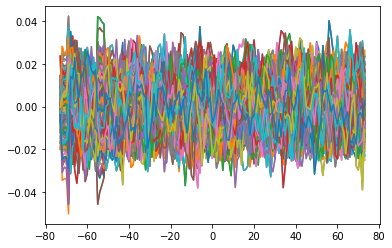

In [2]:
#Cara Baca .h5, Rekomendasi untuk mengukur panjang array dari data kemudian disamakan dengan sb.y
cc_h5 = 'Data Stasiun.h5' 
maxlag = 73
dt = 1
tvec = np.arange(-maxlag,maxlag+dt,dt)

with pyasdf.ASDFDataSet(cc_h5,mode='r') as ds:
    data_type = ds.auxiliary_data.list()
    path = ds.auxiliary_data[data_type[0]].list()
    print(data_type,path)
    
    data = ds.auxiliary_data[data_type[0]][path[0]].data[:]
    para = ds.auxiliary_data[data_type[0]][path[0]].parameters
#     print(data,para)
    print(len(tvec), "tvec")
    print(len(data), "data")
    print(tvec, "tvec")
    # plot the waveform again
    plt.plot(tvec,data)